In [256]:
from drivecycle import route, trajectory, utils, plots, graph, energy

import matplotlib.pyplot as plt
import networkx as nx

import psycopg

import requests
import polyline
import json
import pandas as pd
import numpy as np
import requests

import pickle
import glob
import os

In [257]:
# BC Transit Victoria Route 15
route_id="15"

# Valhalla API
valhalla_host = "http://localhost:8002"

In [258]:
# Connect to gtfs database
conn = psycopg.connect(
        host="localhost",
        dbname="victoria_gtfs",
        user="username",
        password="password",
    )

###  Get Trip IDs for Route

In [259]:
cur = conn.execute(
    "SELECT DISTINCT ON (trips.shape_id) trips.shape_id,trips.trip_id, trips.direction_id, trips.trip_headsign FROM trips " 
    "JOIN routes ON trips.route_id=routes.route_id "
    "WHERE routes.route_short_name=%s ", (route_id,)
    
)
shapes = cur.fetchall()
shapes

[('1-15-147', 'aa5878544', 1, 'Esquimalt via Fort/Yates Exp'),
 ('1-15-150', 'aa5450463', 1, 'Esquimalt via Fort/Yates Exp'),
 ('1-15-151', 'aa6058786', 1, 'Esquimalt via Fort/Yates Exp'),
 ('1-15-154', 'aa6022634', 0, 'UVic via Foul Bay Exp'),
 ('1-15-155', 'aa5449629', 0, 'UVic via Foul Bay Exp'),
 ('1-15-156', 'aa5449936', 1, 'Esquimalt via Fort/Yates Exp')]

### Get shapes for Trips

In [274]:
# Route 15 Eastbound = index 1
# Route 15 Westbound = index 4
route_index = 4

shape = shapes[route_index][0]

cur = conn.execute(
    "SELECT ST_AsGeoJSON(shapes_aggregated.shape) "
    "FROM shapes_aggregated " 
    "WHERE shapes_aggregated.shape_id=%s ", (shape,)
)

line = cur.fetchall()
geojson = json.loads(line[0][0])
coords = [tuple((i[1],i[0])) for i in geojson["coordinates"]]

### Valhalla Trace Attributes

In [275]:
b = polyline.encode(coords, 6)

data =json.dumps({
    "encoded_polyline":b,
    "costing":"auto",
    "filters":
        {
            "attributes":[
                "edge.way_id",
                "edge.names",
                "edge.length",
                "edge.speed",
                "node.intersecting_edge.road_class",
                "node.intersecting_edge.begin_heading",
                "node.elapsed_time","node.type"
                ],
            "action":"include"
        }
    })

height_data = json.dumps({"encoded_polyline":b,"range":True})

In [276]:
# Get Traces (intersections) and elevation from Valhalla
trace = requests.post(f"{valhalla_host}/trace_attributes", data=data)
height = requests.post(f"{valhalla_host}/height", data=height_data)

In [277]:
# Tranformation of Trace attributes so we can input to Drivecycle

edges = trace.json()["edges"]

data_ = []

for edge in edges:
    length = edge["length"]*1000
    speed = edge["speed"]
    way_id = edge["way_id"]
    try:
        intersect = [edge["end_node"]["intersecting_edges"][0]["road_class"]]
    except:
        intersect = [None]

    item = {
        "way_id":way_id,
        "length":length,
        "speed":speed,
        "intersection":intersect,
    }
    data_.append(item)

In [278]:
data_

[{'way_id': 157461209,
  'length': 11.0,
  'speed': 35,
  'intersection': ['service_other']},
 {'way_id': 157461209,
  'length': 34.0,
  'speed': 35,
  'intersection': ['service_other']},
 {'way_id': 157461208,
  'length': 26.0,
  'speed': 35,
  'intersection': ['residential']},
 {'way_id': 8047798,
  'length': 29.0,
  'speed': 35,
  'intersection': ['tertiary']},
 {'way_id': 375332138,
  'length': 89.0,
  'speed': 30,
  'intersection': ['service_other']},
 {'way_id': 375332138,
  'length': 58.0,
  'speed': 30,
  'intersection': ['service_other']},
 {'way_id': 375332138,
  'length': 10.0,
  'speed': 30,
  'intersection': ['service_other']},
 {'way_id': 375332138,
  'length': 30.0,
  'speed': 30,
  'intersection': ['service_other']},
 {'way_id': 375332138, 'length': 20.0, 'speed': 30, 'intersection': [None]},
 {'way_id': 140067104,
  'length': 83.0,
  'speed': 50,
  'intersection': ['service_other']},
 {'way_id': 140067104, 'length': 112.0, 'speed': 50, 'intersection': [None]},
 {'way_i

### Get route stop locations & distances

In [279]:
cur = conn.execute("""
    SELECT ST_LineLocatePoint(
        ST_SetSRID(shape_return.shape,4326), 
        stop_return.stop_loc::geometry) * 
        ST_Length(
            ST_Transform(
                ST_SetSRID(shape_return.shape,4326),
                3005
            )
        ) 
        FROM
    (
    SELECT stop_times.trip_id, trips.shape_id, stops.stop_loc, stop_times.stop_sequence, stop_times.stop_id FROM stop_times
    JOIN stops ON stop_times.stop_id=stops.stop_id
    JOIN trips ON stop_times.trip_id=trips.trip_id
    WHERE stop_times.trip_id=%s
    ORDER BY stop_times.stop_sequence
    ) AS stop_return
    JOIN (
    SELECT shapes_aggregated.shape, shapes_aggregated.shape_id
    FROM shapes_aggregated
    WHERE shapes_aggregated.shape_id=%s
    ) AS shape_return 
    ON stop_return.shape_id=shape_return.shape_id
    """,
    (shapes[route_index][1],shapes[route_index][0]))

distances = cur.fetchall()
stops = [round(i[0],2) for i in distances]
stops

[0.0,
 222.43,
 631.67,
 853.34,
 1209.34,
 1432.29,
 1750.89,
 2072.08,
 2270.85,
 2613.95,
 2828.31,
 3240.44,
 3533.08,
 4096.46,
 4561.51,
 4811.28,
 5268.71,
 5519.94,
 5886.18,
 6340.04,
 6825.21,
 7447.82,
 8367.49,
 8928.7,
 9632.7,
 10425.12,
 10967.81,
 11647.48,
 12282.36,
 12855.6,
 13283.39]

### Combine stop and intersection locations and consolidate graph

In [280]:
a = graph.Graph(data_)
a.include_stops(stops[1:])
a.consolidate_intersections()
a.simplify_graph()
len(a.get_edges())

59

### Get Drive Cycle

In [281]:
# Stop time durations
stop_params={"bus_stop":60,"tertiary":120, "secondary":60}

# Run for 5 iterations
iterations = 5
arr = np.zeros(iterations)

for i in range(iterations):
    dc = route.sequential(a.get_edges(),stops=stop_params, stop_at_node=True, step=1, a_max=1)
    elv = height.json()["range_height"]
    soc = energy.energy_model(dc, elv, m=14465, area=8.9, capacity=555)
    
    total_power = soc[-1,3]
    total_dist = soc[-1,2]
    
    # print(total_power, total_dist)
    
    arr[i]=(total_power/(total_dist/1000))
arr.mean()

INFO:root:Vi: 0.00. Reducing vf to 12.50 and v_target to 12.50 at time 507.0 and segment length 42.440000000000055
INFO:root:Vi: 0.00. Reducing vf to 11.25 and v_target to 11.25 at time 507.0 and segment length 42.440000000000055
INFO:root:Vi: 0.00. Reducing vf to 10.12 and v_target to 10.12 at time 507.0 and segment length 42.440000000000055
INFO:root:Vi: 0.00. Reducing vf to 9.11 and v_target to 9.11 at time 507.0 and segment length 42.440000000000055
INFO:root:Vi: 0.00. Reducing vf to 10.00 and v_target to 10.00 at time 1059.0 and segment length 35.0
INFO:root:Vi: 0.00. Reducing vf to 9.00 and v_target to 9.00 at time 1059.0 and segment length 35.0
INFO:root:Vi: 0.00. Reducing vf to 8.10 and v_target to 8.10 at time 1059.0 and segment length 35.0
INFO:root:Could not complete segment: ti: 1480.00, tf: 4.25,  vi: 13.89 , vf: 0.00,                                 v_target:13.89, length: 59.00
INFO:root:Could not complete segment: ti: 1585.25, tf: 5.65,  vi: 13.89 , vf: 0.00,           

1.2569908300793873

In [284]:
print(f"Total Power: {arr.mean()}")

Total Power: 1.2569908300793873


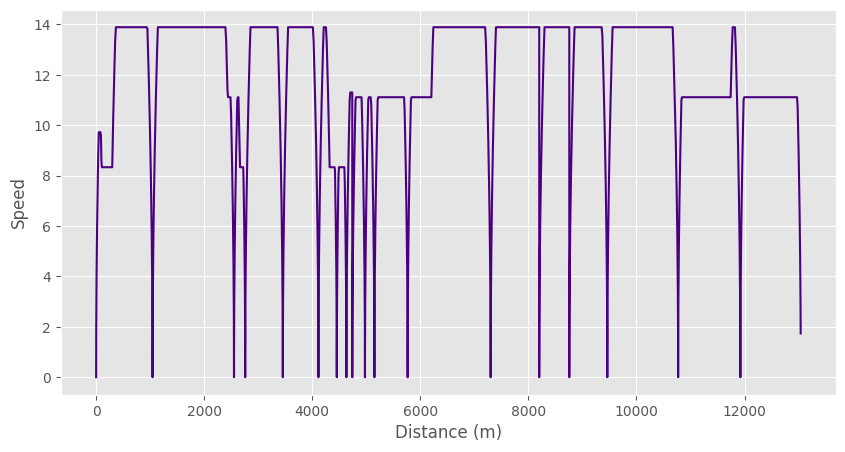

In [285]:
t=[i[2] for i in soc]
p=[i[1] for i in soc]

plt.figure(figsize=(10, 5))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 10})
plt.xlabel("Distance (m)")
plt.ylabel("Speed")
plt.show()

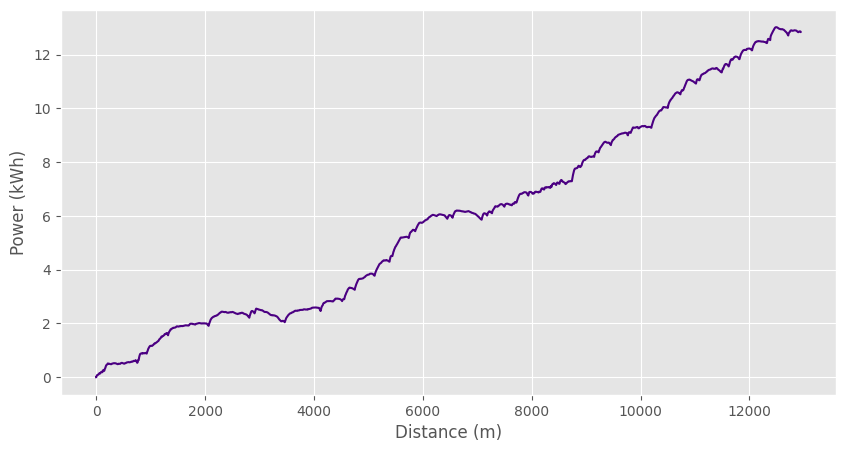

In [244]:
t=[i[2] for i in soc]
p=[i[3] for i in soc]

plt.figure(figsize=(10, 5))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 10})
plt.xlabel("Distance (m)")
plt.ylabel("Power (kWh)")
plt.show()

## Validation with test data

In [287]:
time = pd.read_csv("./test_data/Route15/time.csv", header=0)
distance = pd.read_csv("./test_data/Route15/distance.csv", header=0)
speed = pd.read_csv("./test_data/Route15/speed.csv", header=0)

In [288]:
df = pd.concat((time, speed, distance), axis=1)
test_data = df[(distance.ne(distance.shift())).any(axis=1)] #remove duplicate consecutive distances
test_data = test_data.to_numpy()

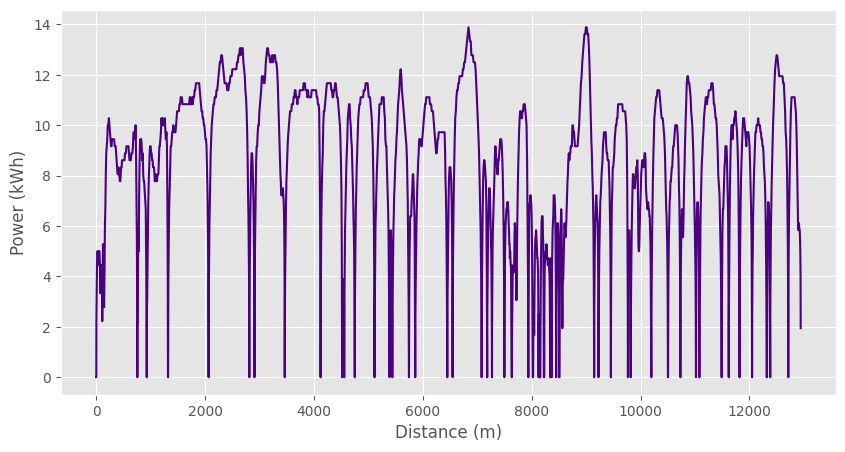

In [289]:
t=[i[2] for i in test_data]
p=[i[1] for i in test_data]

plt.figure(figsize=(10, 5))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 10})
plt.xlabel("Distance (m)")
plt.ylabel("Power (kWh)")
plt.show()

In [271]:
soc = energy.energy_model(test_data, elv, m=14465, area=8.9, capacity=555)

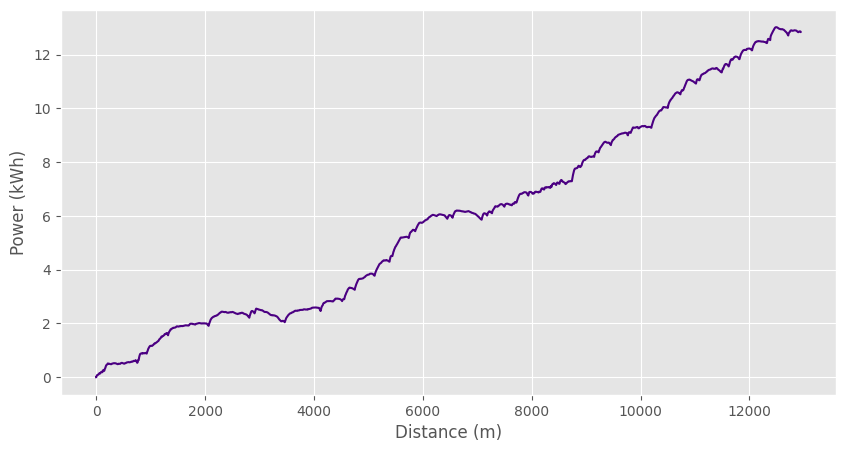

In [272]:
t=[i[2] for i in soc]
p=[i[3] for i in soc]

plt.figure(figsize=(10, 5))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 10})
plt.xlabel("Distance (m)")
plt.ylabel("Power (kWh)")
plt.show()

In [273]:
total_power = soc[-1,3]
total_dist = soc[-1,2]

print(total_power, total_dist)

(total_power/(total_dist/1000))

12.845625780522932 12940.964333


0.9926328092695572

## Summary

|Energy Consumption (kWh/km)       | Eastbound          | Westbound   |
| ------------- |:-------------:| ------:|
| Franca, A. (2015).      |  1.1  | 0.9 |
| Drivecycle Simulation     | 1.26      |   1.08 |
| Drivecycle using test data from Franca, A. (2015).  | -      |    0.99 |